# Audio Exploration: Characteristics, Distribution, Frequency and Spectrograms:

In [74]:
import librosa
from librosa.display import waveshow, specshow, cmap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path, PurePath
import os

import warnings
warnings.filterwarnings("ignore")

In [13]:
DATA_DIR = Path("./dataset/batches")

In [128]:
# random files for research
def get_samples_path(data_directory, n_samples):
    if n_samples == 1:
        return [Path(data_directory, file) for file in np.random.choice(os.listdir(data_directory), n_samples)][0]
    return [Path(data_directory, file) for file in np.random.choice(os.listdir(data_directory), n_samples)]

In [62]:
# get random files for exploration
sample_paths = get_samples_path(data_directory = DATA_DIR, n_samples = 300)

In [63]:
def get_audio_stats(audio_path):
    signal, sr = librosa.load(audio_path, sr = None, mono = False)
    # Channel determination
    channels = "stereo" if len(signal.shape) > 1 and signal.shape[0] == 2 else "mono"
    # Root-mean-square energy (RMSE)
    rmse = np.mean(librosa.feature.rms(y=signal))
    # Average Zero crossing rate
    zcr = np.mean(librosa.zero_crossings(y=signal, pad = False)) / len(signal)
    # Mean amplitude 
    ma = np.mean(signal)
    # Median amplitude
    mda = np.median(signal)
    return {
        "sample_rate" : sr,
        "duration": librosa.get_duration(y=signal, sr=sr),
        "channels": channels,
        "root_mean_square_energy": rmse,
        "zero_crossing_rate_avg": zcr,
        "mean_amplitude": ma,
        "median_amplitude": mda
    }

In [116]:
stats = pd.DataFrame({path: get_audio_stats(audio_path = path) for path in sample_paths}).T.reset_index()

In [117]:
stats.head()

,index,sample_rate,duration,channels,root_mean_square_energy,zero_crossing_rate_avg,mean_amplitude,median_amplitude
0,dataset\batches\9vVjQ4Nqq7M_segment_3.wav,44100,120.0,stereo,0.04471,0.040304,-0.000013,0.0
1,dataset\batches\oN8q7p57nZw_segment_24.wav,44100,120.0,stereo,0.182764,0.00315,-0.000057,-0.000183
2,dataset\batches\9vVjQ4Nqq7M_segment_8.wav,44100,120.0,stereo,0.049843,0.021817,-0.00001,0.000061
3,dataset\batches\ONFCdOEFuqc_segment_49.wav,44100,120.0,stereo,0.260757,0.002852,0.000094,0.000092
4,dataset\batches\oN8q7p57nZw_segment_1.wav,44100,120.0,stereo,0.146797,0.00338,-0.000043,0.0


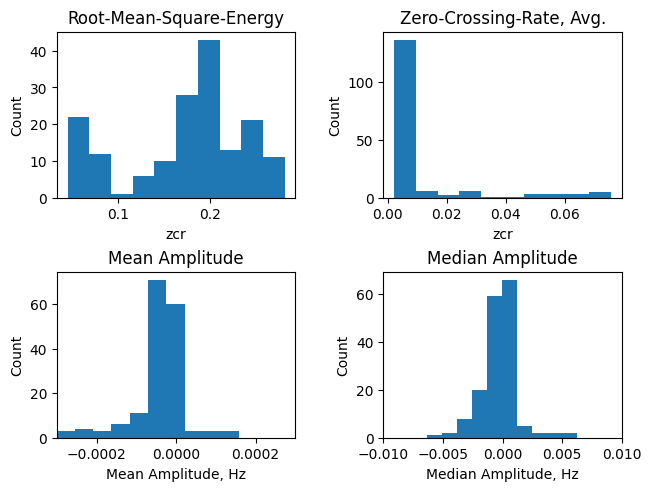

In [118]:
fig, ax = plt.subplots(2, 2, constrained_layout = True)

plt.subplot(2, 2, 1) 
plt.hist(stats.root_mean_square_energy)
plt.title("Root-Mean-Square-Energy")
plt.ylabel("Count")
plt.xlabel("zcr")

plt.subplot(2, 2, 2) 
plt.hist(stats.zero_crossing_rate_avg)
plt.title("Zero-Crossing-Rate, Avg.")
plt.ylabel("Count")
plt.xlabel("zcr")


plt.subplot(2, 2, 3) 
plt.hist(stats.mean_amplitude)
plt.title("Mean Amplitude")
plt.ylabel("Count")
plt.xlim(-0.0003, 0.0003)
plt.xlabel("Mean Amplitude, Hz")

plt.subplot(2, 2, 4) 
plt.hist(stats.median_amplitude)
plt.title("Median Amplitude")
plt.ylabel("Count")
plt.xlabel("Median Amplitude, Hz")
plt.xlim(-0.01, 0.01)
plt.show();


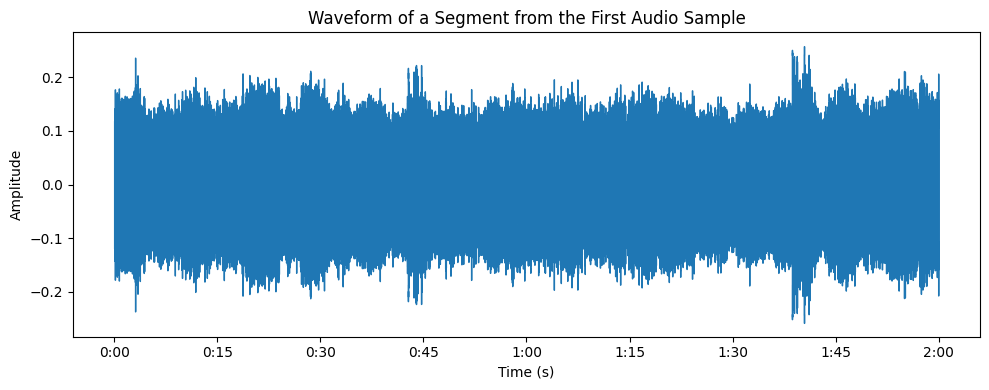

In [119]:
signal, sr = librosa.load(sample_paths[0], sr = None)
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform of a Segment from the First Audio Sample")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

### Preprocessing (draft):

* Convert stereo to mono (in any case)
* Normalize the audio volume levels
* Extract real and imaginary spectrograms for each audio file

In [124]:
def preprocess_audio(audio_path):
    """
    Preprocessing of an audio file:
    - Converts stereo to mono
    - Normalize the volume
    - Extract the real and imaginary spectrograms
    
    :param audio_path: the path to the audio file to read 
    :return: 
        - Real part of the spectrogram
        - Imaginary part of the spectrogram
    """
    # load audio
    y, sr = librosa.load(audio_path, sr = None, mono = True)
    # Normalize 
    y = y / np.max(np.abs(y))
    # Compute STFT to get the complex spectrogram
    complex_spectrogram = librosa.stft(y)
    
    # Split the complex spectrogram into real and imaginary parts
    real_spectrogram = np.real(complex_spectrogram)
    imag_spectrogram = np.imag(complex_spectrogram)
    
    return sr, real_spectrogram, imag_spectrogram

In [125]:
sr, real, imag = preprocess_audio(sample_paths[0])

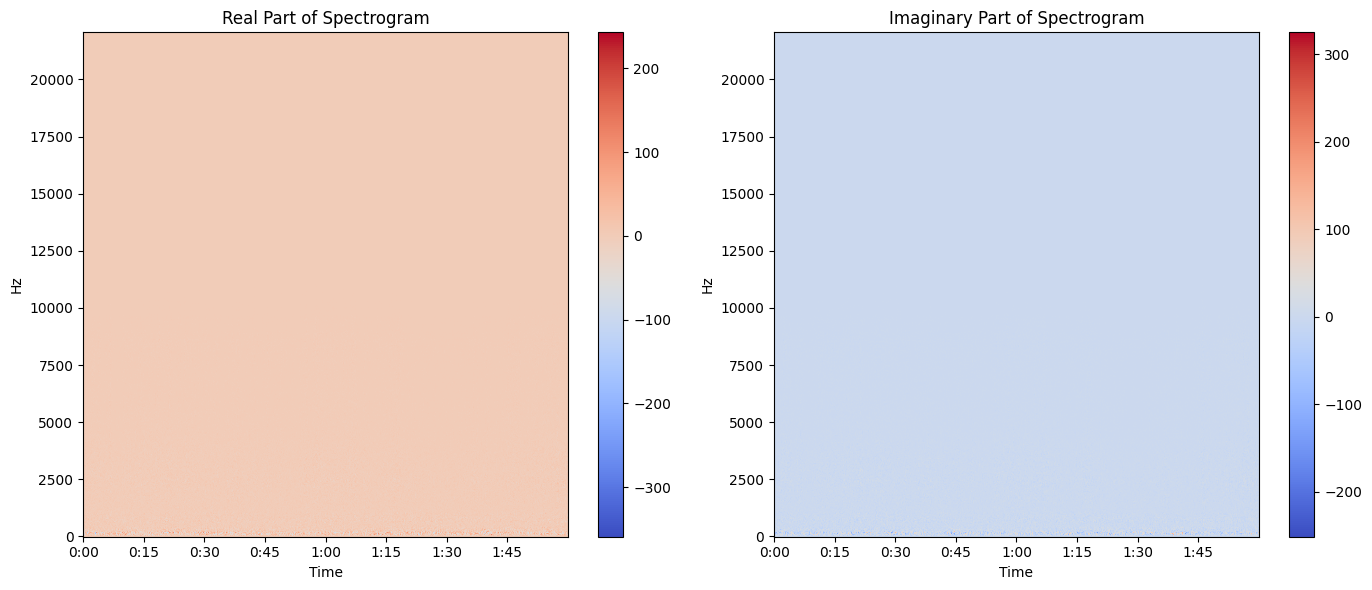

In [127]:
# Display the real and imaginary spectrogram for the first audio sample
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

librosa.display.specshow(real, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title("Real Part of Spectrogram")

plt.subplot(1, 2, 2)

librosa.display.specshow(imag, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title("Imaginary Part of Spectrogram")
plt.tight_layout()

plt.show()

In [129]:
# Preprocessing class for module 
class AudioPreprocessor:
    def __init__(self, sample_rate=44100):
        self.sample_rate = sample_rate
        
    def preprocess(self, audio_path):
        y, sr = librosa.load(audio_path, sr = self.sample_rate, mono = True)
        y = y / np.max(np.abs(y))
        complex_spectrogram = librosa.stft(y)
        real_spectrogram, imag_spectrogram = np.real(complex_spectrogram), np.imag(complex_spectrogram)
        return y, sr, real_spectrogram, imag_spectrogram

# Model's architecture: Deep Concolutional Neural Network:

In [160]:
import torch.nn as nn
from torch.nn import functional as F

class DeepCRN(torch.nn.Module):
    def __init__(self):
        super(DeepCRN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=32, hidden_size=32, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        
        # Deconvolution layers
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.deconv4 = nn.ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        
        self.fc1 = nn.Linear(128, 32)
        
    def forward(self, x):
        # Convolutional layers
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        x4 = self.pool(F.relu(self.conv4(x3)))
        
        # Reshaping for LSTM layers
        batch_size, channels, height, width = x4.size()
        x_lstm = x4.view(batch_size, height, -1)
        x_lstm = self.fc1(x_lstm)  # Using fully connected layer to transform dimensions
        
        # LSTM layers
        x_lstm, _ = self.lstm1(x_lstm)
        x_lstm, _ = self.lstm2(x_lstm)
        
        # Reshaping back for deconvolution layers
        x_deconv = x_lstm.view(batch_size, 128, height, -1)
        
        # Deconvolution layers
        x5 = F.interpolate(F.relu(self.deconv1(x_deconv + x3)), scale_factor=2)
        x6 = F.interpolate(F.relu(self.deconv2(x5 + x2)), scale_factor=2)
        x7 = F.interpolate(F.relu(self.deconv3(x6 + x1)), scale_factor=2)
        x8 = self.deconv4(x7)
        
        return x8

# TODO: Draft architecture not tested (probably wrong skip connections)

In [162]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_instance = DeepCRN()

In [164]:
model_instance.parameters

<bound method Module.parameters of DeepCRN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lstm1): LSTM(32, 32, batch_first=True)
  (lstm2): LSTM(32, 64, batch_first=True)
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv4): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=128, out_features=32, bias=True)
)>